## Introduction

### In this notebook we use [UNet](https://arxiv.org/abs/1505.04597) segmentation model for performing building segmentation on [Massachusetts Buildings Dataset](https://www.cs.toronto.edu/~vmnih/docs/Mnih_Volodymyr_PhD_Thesis.pdf).

### Libraries 📚⬇

install the following library otherwise there is an error:AttributeError: module 'albumentations' has no attribute 'Lambda'

In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rr5xzs3o
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rr5xzs3o
     |████████████████████████████████| 952kB 4.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.0-cp36-none-any.whl size=70569 sha256=a833fa2ba8c9c69fbb45951f383d7753b6631a82f6df43519f4a1588002eb2a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-w_lispav/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Defining train / val / test directories 📁

In [5]:
#DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'
BASE_DIR="/content/drive/My Drive/06CNN/assignment/"
DATA_DIR = "/content/drive/My Drive/06CNN/assignment/4D"
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [6]:
class_dict = pd.read_csv(os.path.join(BASE_DIR+"label_class_dict.csv"))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [7]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [8]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [9]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            y=None,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
            
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    
    def __getitem__(self, i):
        
        # read images and masks
        #cv2.IMREAD_ANYDEPTH
        #cv2.imread(self.image_paths[i]), cv2.IMREAD_ANYDEPTH)
        #Vec3b image = imread(self.image_paths[i]),cv2.CV_LOAD_IMAGE_UNCHANGED);
        #cv2.imread(self.image_paths[i]), cv2.IMREAD_ANYDEPTH)
        #import pdb; pdb.set_trace()
        #y=cv2.imread(self.image_paths[i])
       # import pdb; pdb.set_trace()
        image = cv2.cvtColor(cv2.imread(self.image_paths[i],cv2.CV_16U), cv2.CV_16U)
        #swith band1 and band 4
        band1 =image[0,:,:]  #height
        band2 =image[1,:,:]  #red band1
        band3 =image[2,:,:]  #blue band3
        band4 =image[3,:,:]  #green band2
        # image[0,:,:]=band4
        #image[3,:,:]=band1
        image[0,:,:]=band2 #red
        image[1,:,:]=band3 #gree
        image[2,:,:]=band4 #blue
        image[3,:,:]=band1
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        #by me use corss entropy need long
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
       # mask = one_hot_encode(mask, self.class_rgb_values).astype('long')
        
        # apply augmentations
        if self.augmentation:
            #import pdb; pdb.set_trace()
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #by me use corss entropy need long
            #image=image.astype('long')
            #mask= mask.astype('long')
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [10]:
#image[0,:,:]

#### Visualize Sample Image and Mask 📈

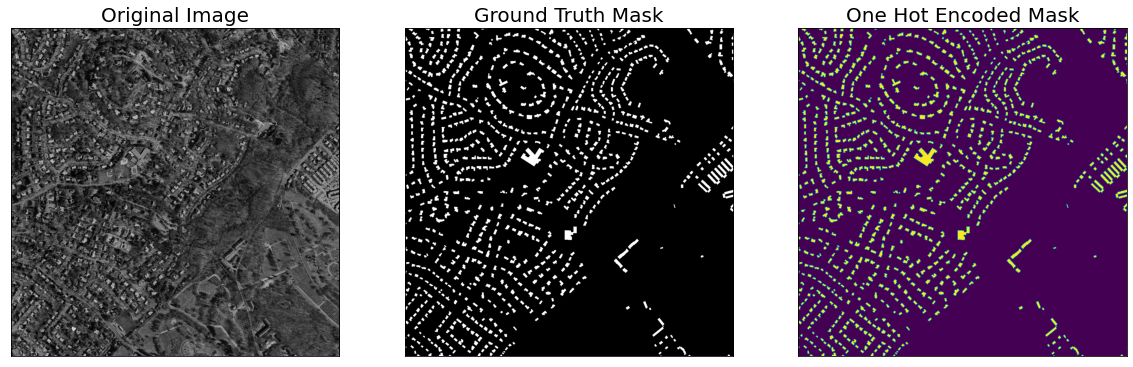

In [11]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[0]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [12]:
# cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_012.png"), np.hstack(image[:,:,(0,1,2)]))

In [13]:
# cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_210.png"), np.hstack(image[:,:,(2,1,0)]))

### Defining Augmentations 🙃

In [14]:
def get_training_augmentation():
    train_transform = [
        album.CenterCrop(height=1500, width=1500, always_apply=True), 
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

#pdb.set_trace()
def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    #CenterCrop or resize
    test_transform = [
       #1536
        album.CenterCrop(height=1500, width=1500, always_apply=True),
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        #album.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(test_transform)

def get_test_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    #CenterCrop or resize
    test_transform = [
       #1536
        album.CenterCrop(height=1500, width=1500, always_apply=True),
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
        #album.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return album.Compose(test_transform)
    
    
#import pdb; pdb.set_trace()

def to_tensor(x, **kwargs):
   return x.transpose(2, 0, 1).astype('float32')
   #return x.transpose(2, 0, 1).astype('long')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

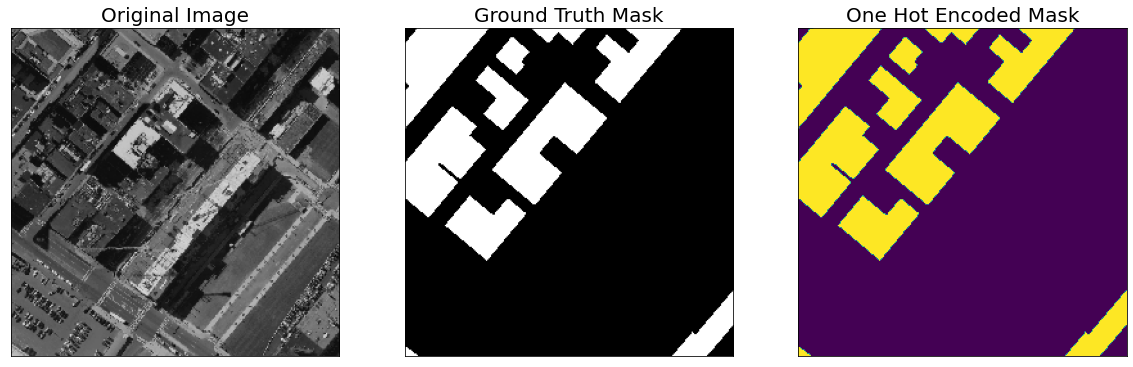

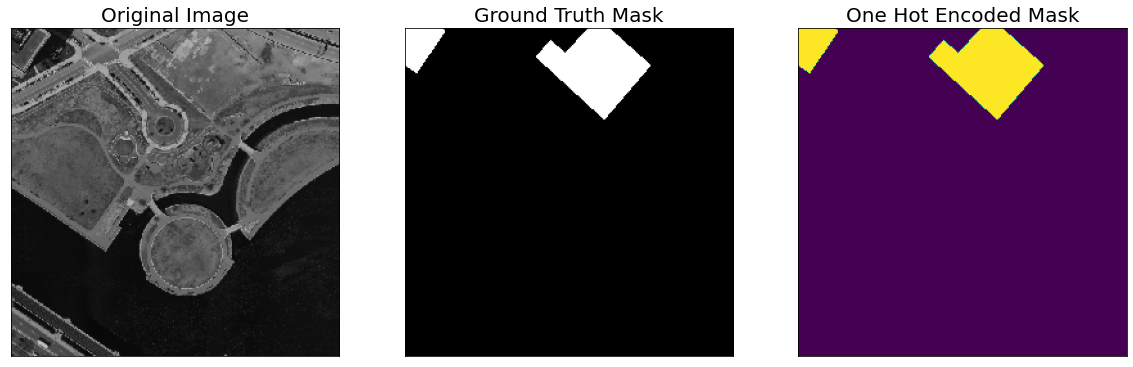

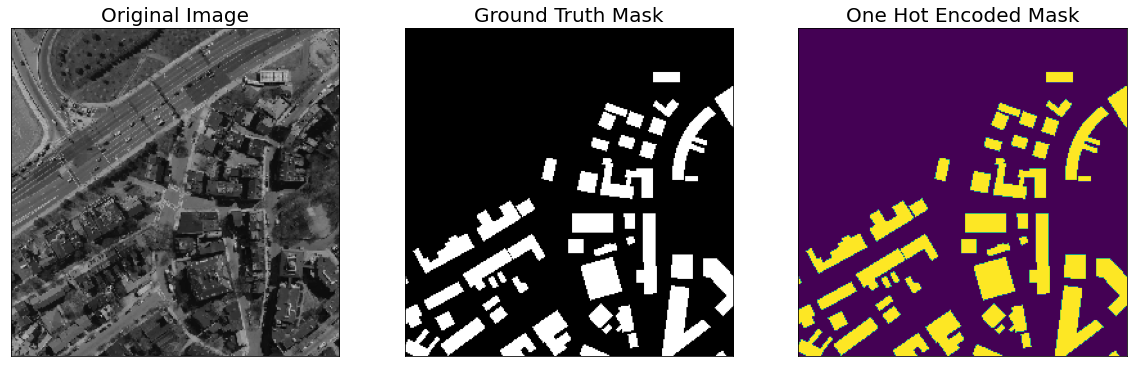

In [15]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Model Definition

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(4, 64)
        #self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
        
    

# Get UNet model
model = UNet()

#### Get Train / Val DataLoaders

In [17]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)
#import pdb; 
#pdb.set_trace()
valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
##In the dataloader set:
#train_dataset.
#train_dataset. = train_dataset.target.to(dtype=torch.long)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=8)
#train_dataset = train_dataset.to(dtype=torch.long)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)


In [18]:
#by me   Input type (torch.cuda.LongTensor) and weight type (torch.cuda.FloatTensor) should be the same
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
#         train_loader[i].inputs=inputs
#         train_loader[i].labels=labels
#         #data.to(device)
# for i, data in enumerate(valid_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
#model.to(device)


In [19]:
#train_loader.dataset[1]
#inputs

In [20]:
#train_dataset[1]
#model.cuda()


#### Set Hyperparams

In [21]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
#EPOCHS = 120 #20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function #DiceLoss
loss = smp.utils.losses.BCEWithLogitsLoss()#smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    #without threshold there is a error in the following code section
    #smp.utils.metrics.Accuracy(threshold=0.5),
    #smp.utils.metrics.Recall,
    #smp.utils.metrics.Precision,
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
#os.path.join(BASE_DIR, 'train')
#if os.path.exists(os.path.join(BASE_DIR, 'best_model_unet_for_building.pth')):
    #print("load best_model_pth")
   # model = torch.load(os.path.join(BASE_DIR, 'best_model_unet_for_building.pth'), map_location=DEVICE)

In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training UNet

### Prediction on Test Data

In [23]:
%%time
EPOCHS = 120 #20
pth='pretrain_unet_4b_120.pth'
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        #https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
       # model.to(device)
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, os.path.join(BASE_DIR, pth))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it, bce_with_logits_loss - 0.6876, iou_score - 0.01063]
Model saved!

Epoch: 1
valid: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, bce_with_logits_loss - 0.6932, iou_score - 0.1247]
Model saved!

Epoch: 2
valid: 100%|██████████| 11/11 [00:13<00:00,  1.26s/it, bce_with_logits_loss - 0.5646, iou_score - 0.3409]
Model saved!

Epoch: 3
valid: 100%|██████████| 11/11 [00:12<00:00,  1.17s/it, bce_with_logits_loss - 0.579, iou_score - 0.4542]
Model saved!

Epoch: 4
valid: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, bce_with_logits_loss - 0.8864, iou_score - 0.2661]

Epoch: 5
valid: 100%|██████████| 11/11 [00:13<00:00,  1.21s/it, bce_with_logits_loss - 0.6186, iou_score - 0.4001]

Epoch: 6
valid: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it, bce_with_logits_loss - 0.5704, iou_score - 0.4061]

Epoch: 7
valid: 100%|██████████| 11/11 [00:13<00:00,  1.19s/it, bce_with_logits_loss - 0.5668, iou_score - 0.4252]

Epoch: 8
valid: 100

the original pth file is rename as "best_model_unet_for_building.pth"

In [24]:
# load best saved model checkpoint from the current run

if os.path.exists(os.path.join(BASE_DIR, pth)):
    best_model = torch.load(os.path.join(BASE_DIR, pth), map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
#elif os.path.exists(os.path.join(BASE_DIR, 'best_model_unet_for_building.pth')):
   # best_model = torch.load(os.path.join(BASE_DIR, 'best_model_unet_for_building.pth'), map_location=DEVICE)
    #print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


use the pretrained model (unet)

In [25]:
#best_model = torch.load(os.path.join(BASE_DIR, 'selftrain_best_model_unet_for_building1.pth'), map_location=DEVICE)
#print('Loaded UNet model from a previous commit.')

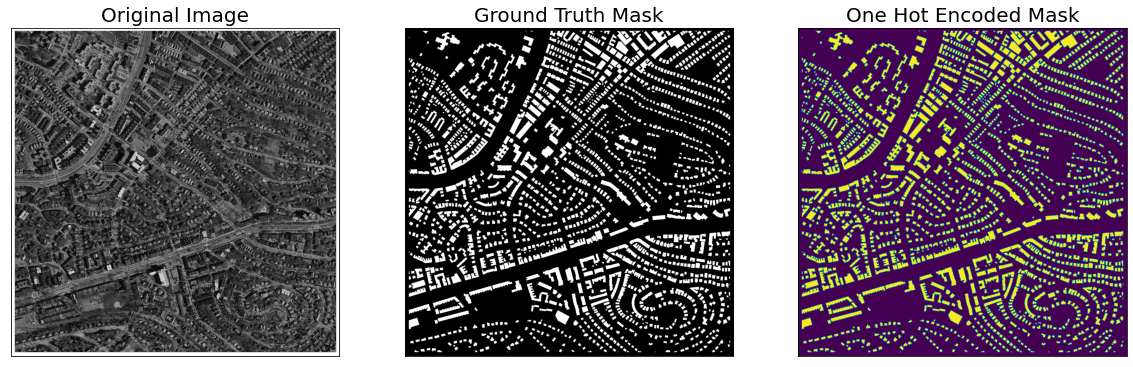

In [26]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_test_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_test_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [27]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [28]:
sample_preds_folder = os.path.join(BASE_DIR, 'pretrainsample_DECloss120')
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [29]:
for idx in range(len(test_dataset)):

    # random_idx = random.randint(0, len(test_dataset)-1)
    #random_idx=3
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis[:,:,0:-1], gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

Output hidden; open in https://colab.research.google.com to view.

https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch

In [30]:
#  import gc
#  del train_logs_list,valid_logs,valid_logs_list#model,train_loader, valid_loader, train_dataset, valid_dataset, dataset
#  gc.collect()

### Model Evaluation on Test Dataset

In [31]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

#valid_logs = test_epoch.run(test_dataloader)
test_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {test_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {test_logs['bce_with_logits_loss']:.4f}")

valid: 100%|██████████| 11/11 [00:15<00:00,  1.38s/it, bce_with_logits_loss - 0.2609, iou_score - 0.7915]
Evaluation on Test Data: 
Mean IoU Score: 0.7915
Mean Dice Loss: 0.2609


### Plot Dice Loss & IoU Metric for Train vs. Val

In [32]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119
bce_with_logits_loss,0.668268,0.609477,0.549718,0.538343,0.52652,0.513493,0.498993,0.497761,0.491759,0.483032,0.474409,0.462995,0.440105,0.460313,0.431726,0.464193,0.419102,0.414966,0.411524,0.428057,0.403279,0.442375,0.406290,0.394724,0.395289,0.385242,0.403822,0.404268,0.403915,0.364586,0.398114,0.377531,0.393306,0.390150,0.381937,0.384696,0.353521,0.362321,0.385281,0.370151,...,0.271625,0.313731,0.331332,0.305669,0.298388,0.298253,0.277450,0.306967,0.277619,0.337379,0.301600,0.296456,0.282982,0.296916,0.303157,0.296225,0.286894,0.287869,0.308635,0.293117,0.287450,0.256873,0.328345,0.342888,0.297586,0.298656,0.310164,0.30283,0.278106,0.298380,0.290217,0.258716,0.279198,0.295162,0.295262,0.297686,0.268452,0.278584,0.244961,0.290038
iou_score,0.099181,0.193756,0.357412,0.446919,0.52528,0.532372,0.584372,0.564571,0.612077,0.642168,0.609910,0.619106,0.664216,0.649493,0.693535,0.623709,0.693029,0.709033,0.710270,0.656220,0.689384,0.679520,0.684022,0.694691,0.684741,0.721639,0.686676,0.701131,0.666750,0.724376,0.689229,0.706399,0.693321,0.678379,0.716269,0.687633,0.714000,0.733628,0.677589,0.705298,...,0.786683,0.736985,0.710875,0.754772,0.753397,0.763748,0.783945,0.751063,0.781339,0.711522,0.766242,0.756637,0.765692,0.748274,0.756902,0.764819,0.768433,0.765769,0.753464,0.761277,0.772161,0.789897,0.732046,0.739737,0.751178,0.760052,0.748233,0.74294,0.771882,0.765548,0.768386,0.803966,0.762812,0.752465,0.757366,0.748696,0.784260,0.771334,0.807128,0.763793


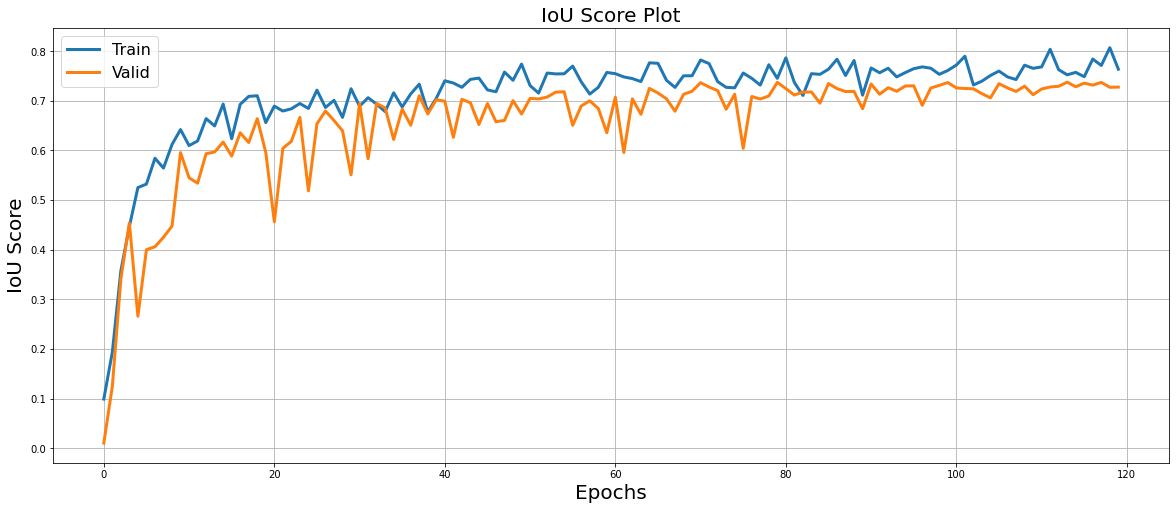

In [33]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

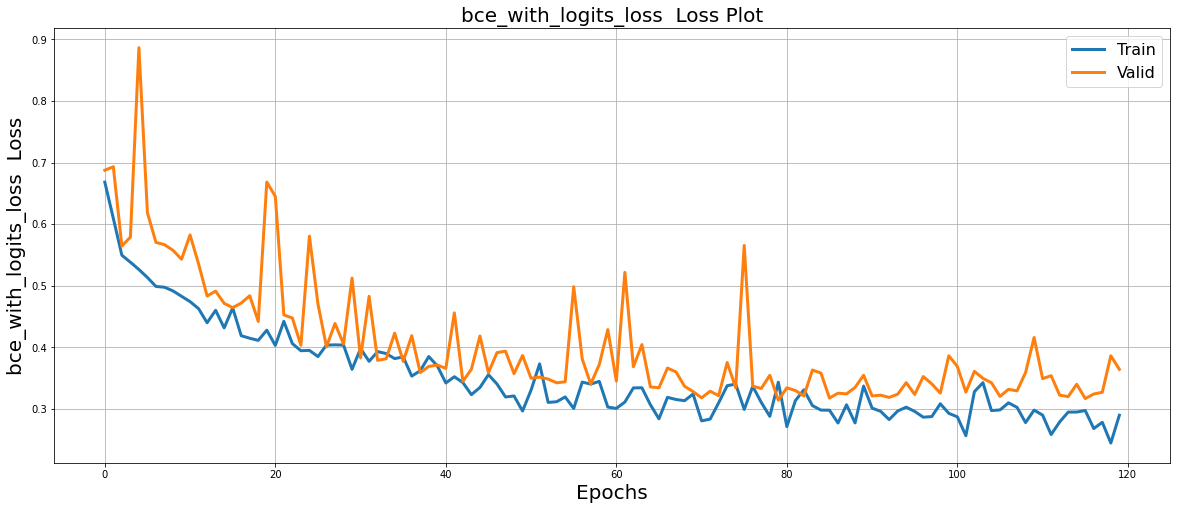

In [34]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.bce_with_logits_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.bce_with_logits_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('bce_with_logits_loss  Loss', fontsize=20)
plt.title('bce_with_logits_loss  Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('bce_with_logits_loss_plot.png')
plt.show()

In [35]:
# plt.figure(figsize=(20,8))
# plt.plot(train_logs_df.index.tolist(), train_logs_df.accuracy.tolist(), lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.accuracy.tolist(), lw=3, label = 'Valid')
# plt.xlabel('Epochs', fontsize=20)
# #plt.plot(1-np.array(history.history["acc"]))
# plt.ylabel('accuracy', fontsize=20)
# plt.title('accuracy Plot', fontsize=20)
# plt.legend(loc='best', fontsize=16)
# plt.grid()
# plt.savefig('accuracy_plot.png')
# plt.show()